In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

In [2]:
heros = pd.read_csv('../dataset/hero_names.csv')
items = pd.read_csv('../dataset/item_ids.csv')
matches = pd.read_csv('../dataset/match.csv')
players = pd.read_csv('../dataset/players.csv')

In [79]:
players.head()

,match_id,account_id,hero_id,player_slot,gold,gold_spent,gold_per_min,xp_per_min,kills,deaths,...,unit_order_glyph,unit_order_eject_item_from_stash,unit_order_cast_rune,unit_order_ping_ability,unit_order_move_to_direction,unit_order_patrol,unit_order_vector_target_position,unit_order_radar,unit_order_set_item_combine_lock,unit_order_continue
0,0,0,86,0,3261,10960,347,362,9,3,...,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1,51,1,2954,17760,494,659,13,3,...,NaN,NaN,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,83,2,110,12195,350,385,0,4,...,NaN,NaN,NaN,17.0,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2,11,3,1179,22505,599,605,8,4,...,1.0,NaN,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN
4,0,3,67,4,3307,23825,613,762,20,3,...,3.0,NaN,NaN,23.0,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
heros_dict = dict(zip(heros['hero_id'], heros['localized_name']))
heros_dict[0] = 'None'

In [5]:
prep = pd.DataFrame()
prep['hero'] = players['hero_id'].apply(lambda id: heros_dict[id])

In [6]:
prep.head()

,hero
0,Rubick
1,Clockwerk
2,Treant Protector
3,Shadow Fiend
4,Spectre


In [7]:
prep.shape

(500000, 1)

In [8]:
items.head()

,item_id,item_name
0,1,blink
1,2,blades_of_attack
2,3,broadsword
3,4,chainmail
4,5,claymore


In [9]:
items_dict = dict(zip(items['item_id'], items['item_name']))
items_dict[0] = 'None'
items.head()

,item_id,item_name
0,1,blink
1,2,blades_of_attack
2,3,broadsword
3,4,chainmail
4,5,claymore


In [10]:
def finditem(id):
    return items_dict.get(id, 'u_'+str(id))

for itemIdx in range(0,6):
    prep['item_'+str(itemIdx)] = players['item_'+str(itemIdx)].apply(finditem)

In [11]:
prep.head()

,hero,item_0,item_1,item_2,item_3,item_4,item_5
0,Rubick,arcane_boots,ghost,bracer,ring_of_health,ultimate_scepter,None
1,Clockwerk,tpscroll,power_treads,shivas_guard,force_staff,ultimate_orb,ultimate_scepter
2,Treant Protector,travel_boots,point_booster,energy_booster,ultimate_scepter,hand_of_midas,None
3,Shadow Fiend,power_treads,manta,sange_and_yasha,helm_of_the_dominator,mekansm,skadi
4,Spectre,heart,urn_of_shadows,manta,None,radiance,power_treads


In [12]:
players_heroes = pd.get_dummies(prep['hero'])
players_heroes.head()

,Abaddon,Alchemist,Ancient Apparition,Anti-Mage,Axe,Bane,Batrider,Beastmaster,Bloodseeker,Bounty Hunter,...,Venomancer,Viper,Visage,Warlock,Weaver,Windranger,Winter Wyvern,Witch Doctor,Wraith King,Zeus
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
players_heroes.shape

(500000, 111)

In [14]:
player_item_dict = {}
for itemIdx in range(0, 6):
    player_item_dict['item_'+str(itemIdx)] = pd.get_dummies(players['item_'+str(itemIdx)].fillna(0))

In [15]:
player_item_dict['item_0']

,0,1,2,3,4,5,6,7,8,9,...,226,229,230,231,235,241,242,247,249,254
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
499996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
499997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
499998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [16]:
player_items = player_item_dict['item_0'].add(player_item_dict['item_1'], fill_value=0).add(player_item_dict['item_2'], fill_value=0).add(player_item_dict['item_3'], fill_value=0).add(player_item_dict['item_4'], fill_value=0).add(player_item_dict['item_5'], fill_value=0)

In [107]:
player_items

,0,1,2,3,4,5,6,7,8,9,...,230,231,235,241,242,243,247,248,249,254
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0,0,0.0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0,0,0.0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0,0,0.0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0,0,0.0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0,0,0.0,1,0
499996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0,0,0.0,0,0
499997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0,0,0.0,0,0
499998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0,0,0.0,1,0


In [144]:
players_gold = {}
players_gold['gold_spent'] = players['gold_spent']
players_gold['gold_destroying_structure'] = players['gold_destroying_structure']
players_gold['gold_killing_heros'] = players['gold_killing_heros']
players_gold['gold_killing_creeps'] = players['gold_killing_creeps']

players_golds_labels = ['gold_spent', 'gold_destroying_structure', 'gold_killing_heros', 'gold_killing_creeps']

p_golds = pd.DataFrame(players_gold, columns=players_golds_labels)
p_golds.fillna(0)

,gold_spent,gold_destroying_structure,gold_killing_heros,gold_killing_creeps
0,10960,3120.0,5145.0,1087.0
1,17760,3299.0,6676.0,4317.0
2,12195,3142.0,2418.0,3697.0
3,22505,4714.0,4104.0,10432.0
4,23825,3217.0,7467.0,9220.0
...,...,...,...,...
499995,17735,3860.0,9377.0,2940.0
499996,20815,4945.0,8292.0,4346.0
499997,16225,3860.0,4027.0,3833.0
499998,31015,4668.0,5152.0,12927.0


In [145]:
r_heroes_cols = list(map(lambda title: 'r_' + str(title), players_heroes.columns.values))
d_heroes_cols = list(map(lambda title: 'd_' + str(title), players_heroes.columns.values))
r_items_cols = list(map(lambda title: 'r_' + str(title), player_items.columns.values))
d_items_cols = list(map(lambda title: 'd_' + str(title), player_items.columns.values))

In [146]:
r_hero_list = []
d_hero_list = []
r_item_list = []
d_item_list = []
r_gold_list = []
d_gold_list = []

for id, idx in players.groupby('match_id').groups.items():
    r_hero_list.append(players_heroes.iloc[idx][:5].sum().values)
    d_hero_list.append(players_heroes.iloc[idx][5:].sum().values)
    r_item_list.append(player_items.iloc[idx][:5].sum().values)
    d_item_list.append(player_items.iloc[idx][5:].sum().values)
    r_gold_list.append(p_golds.iloc[idx][:5].sum().values)
    d_gold_list.append(p_golds.iloc[idx][5:].sum().values)

In [147]:
r_gold_cols = ['r_gold_spent', 'r_gold_destroying_structure', 'r_gold_killing_heros', 'r_gold_killing_creeps']
d_gold_cols = ['d_gold_spent', 'd_gold_destroying_structure', 'd_gold_killing_heros', 'd_gold_killing_creeps']

In [148]:
r_heroes = pd.DataFrame(r_hero_list, columns=r_heroes_cols)
d_heroes = pd.DataFrame(d_hero_list, columns=d_heroes_cols)
r_items = pd.DataFrame(r_item_list, columns=r_items_cols)
d_items = pd.DataFrame(d_item_list, columns=d_items_cols)
r_gold = pd.DataFrame(r_gold_list, columns=r_gold_cols)
d_gold = pd.DataFrame(d_gold_list, columns=d_gold_cols)

X = pd.DataFrame()
X = pd.concat([r_heroes, d_heroes, r_items, d_items, r_gold, d_gold], axis=1)

In [149]:
X.shape

(50000, 620)

In [69]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 612 entries, r_Abaddon to d_254
dtypes: float64(390), int64(222)
memory usage: 233.5 MB


In [70]:
X.describe()

,r_Abaddon,r_Alchemist,r_Ancient Apparition,r_Anti-Mage,r_Axe,r_Bane,r_Batrider,r_Beastmaster,r_Bloodseeker,r_Bounty Hunter,...,d_230,d_231,d_235,d_241,d_242,d_243,d_247,d_248,d_249,d_254
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.0000,50000.000000,50000.0000,50000.000000,50000.000000
mean,0.033720,0.099260,0.067620,0.092740,0.045820,0.02560,0.009960,0.012980,0.029980,0.067040,...,0.000520,0.207060,0.145020,0.002580,0.079260,0.0001,0.089120,0.0001,0.160280,0.275180
std,0.180509,0.299014,0.251095,0.290071,0.209097,0.15794,0.099303,0.113189,0.170534,0.250094,...,0.022798,0.410304,0.378777,0.055977,0.272726,0.0100,0.313017,0.0100,0.394149,0.497133
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.0000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.0000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.0000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.0000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,...,1.000000,2.000000,3.000000,4.000000,2.000000,1.0000,4.000000,1.0000,3.000000,4.000000


In [71]:
X.corr()

,r_Abaddon,r_Alchemist,r_Ancient Apparition,r_Anti-Mage,r_Axe,r_Bane,r_Batrider,r_Beastmaster,r_Bloodseeker,r_Bounty Hunter,...,d_230,d_231,d_235,d_241,d_242,d_243,d_247,d_248,d_249,d_254
r_Abaddon,1.000000,-0.013470,-0.018095,-0.003193,-0.006493,-0.012741,0.001347,-0.007718,-0.011400,-0.009317,...,0.005459,0.021036,-0.008338,0.007225,0.000962,-0.001868,0.000617,-0.001868,-0.017213,-0.012025
r_Alchemist,-0.013470,1.000000,-0.003090,-0.040646,-0.010686,-0.007645,-0.004332,-0.003794,-0.005801,-0.002599,...,0.012966,-0.014450,0.304486,0.000234,-0.004014,-0.003320,0.058699,0.003369,0.016212,-0.008035
r_Ancient Apparition,-0.018095,-0.003090,1.000000,0.000122,-0.003397,-0.019443,-0.005354,0.008525,-0.008577,-0.019957,...,0.000845,-0.010302,0.017599,0.001817,-0.011384,-0.002693,0.002210,-0.002693,0.004869,-0.026178
r_Anti-Mage,-0.003193,-0.040646,0.000122,1.000000,-0.001473,0.001874,0.003344,-0.006206,-0.014967,-0.010715,...,0.001781,-0.020357,-0.036126,0.004972,-0.010752,-0.003197,-0.037282,-0.003197,-0.036599,0.000692
r_Axe,-0.006493,-0.010686,-0.003397,-0.001473,1.000000,-0.005844,-0.003678,-0.011609,-0.015528,-0.014759,...,-0.004998,-0.026663,-0.016475,-0.008391,0.217945,0.007374,-0.019916,-0.002191,-0.025287,-0.033370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
d_243,-0.001868,-0.003320,-0.002693,-0.003197,0.007374,-0.001621,-0.001003,-0.001147,-0.001758,-0.002681,...,-0.000228,0.009577,-0.003829,-0.000461,-0.002906,1.000000,0.003543,-0.000100,0.001008,-0.001512
d_247,0.000617,0.058699,0.002210,-0.037282,-0.019916,0.001184,-0.009897,-0.007248,-0.002844,0.005945,...,-0.000889,0.023256,0.044330,-0.009698,0.001363,0.003543,1.000000,-0.002847,0.042926,0.007814
d_248,-0.001868,0.003369,-0.002693,-0.003197,-0.002191,-0.001621,-0.001003,-0.001147,-0.001758,0.005317,...,-0.000228,-0.000172,-0.003829,-0.000461,-0.002906,-0.000100,-0.002847,1.000000,0.001008,-0.005536
d_249,-0.017213,0.016212,0.004869,-0.036599,-0.025287,-0.010974,-0.012683,-0.014804,0.022537,-0.020951,...,-0.000372,0.006013,-0.000159,-0.002426,-0.006733,0.001008,0.042926,0.001008,1.000000,-0.002888


In [150]:
y_arr = OrdinalEncoder().fit_transform(matches['radiant_win'].values.reshape(-1,1))
col = ['r_win']
y = pd.DataFrame(y_arr, columns=col)


,r_win
0,1.0
1,0.0
2,0.0
3,0.0
4,1.0


In [151]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 1st attempt


In [152]:
cal_svc = CalibratedClassifierCV(
            base_estimator=LinearSVC(
                random_state=42, 
                C=10, 
                max_iter=1500, 
                verbose=False), 
            method='sigmoid', cv=5)
cal_svc.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=LinearSVC(C=10, class_weight=None,
                                                dual=True, fit_intercept=True,
                                                intercept_scaling=1,
                                                loss='squared_hinge',
                                                max_iter=1500,
                                                multi_class='ovr', penalty='l2',
                                                random_state=42, tol=0.0001,
                                                verbose=False),
                       cv=5, method='sigmoid')

In [153]:
y_pred = cal_svc.predict(X_test)
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

[[4759   56]
 [  53 5132]]
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      4815
         1.0       0.99      0.99      0.99      5185

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [154]:
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))

Accuracy:  0.9891


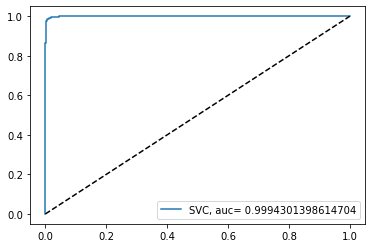

In [155]:
y_pred_proba = cal_svc.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr, tpr, label="SVC, auc= " + str(auc))
plt.plot([0,1],[0,1],'k--')
plt.legend(loc=4)
plt.show()

AttributeError: 'CalibratedClassifierCV' object has no attribute 'feature_importances_'

### 1st attempt summary

### 2nd attempt

In [96]:
scale_pipe = Pipeline([
    ('standardscale', StandardScaler()),
    ('cal_linsvc', CalibratedClassifierCV(
        base_estimator=LinearSVC(random_state=42, C=10.0, max_iter=1500, verbose=False),
        cv=5, method='sigmoid'))
])

NameError: name 'Pipeline' is not defined